# Improving Demand Forecasting
## Capstone Project 2: Exploratory & Statistical Data Analysis

This data science study focuses on the analysis of a time series that describes the sales of items at multiple stores. In this exploration, the dataset is imported from a csv file into a pandas dataframe. The general properties of the dataset are revealed with descriptive statistics and time series plots of the total sales numbers. 

Statistical and visual data analysis are performed to check for the trend, seasonality, variance, autocorrelation, and stationarity of the time series. By the end of this exploration, the dataset is ready for time series modeling.

In [3]:
%matplotlib inline

import warnings
import itertools
import numpy as np
warnings.filterwarnings("ignore")

import lightgbm as lgb

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats

PROJ_ROOT = os.pardir

## Importing data
Dataset: Store Item Demand Forecasting Challenge from Kaggle

https://www.kaggle.com/c/demand-forecasting-kernels-only/data

The dataset provided comes in 2 csv files, train.csv and test.csv. The training dataset with sales numbers is imported for exploratory data analysis. The training dataset contains 913000 sales records of 50 items across 10 stores. The sales numbers per day for the 50 items range from 0 to 231 with a mean of 52. The sales records are from 2013 to the end of 2017.

In [11]:
sales_data_path = os.path.join(PROJ_ROOT, "data", "raw", "train.csv")

df = pd.read_csv(sales_data_path, parse_dates=["date"])
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [8]:
print('Time period start: {}\nTime period end: {}'.format(df.date.min(),df.date.max()))

Time period start: 2013-01-01 00:00:00
Time period end: 2017-12-31 00:00:00


In [9]:
df.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

In [10]:
df.shape

(913000, 4)

In [12]:
dates = df.date
df['month'] = dates.dt.to_period('m')

In [12]:
df_month = pd.DataFrame({'sales': df.groupby('month')['sales'].sum()})

#### Monthly Total Sales
Reviewing the monthly total sales numbers over time for all items in all stores reveals a time series with seasonality and an upwards trend. 

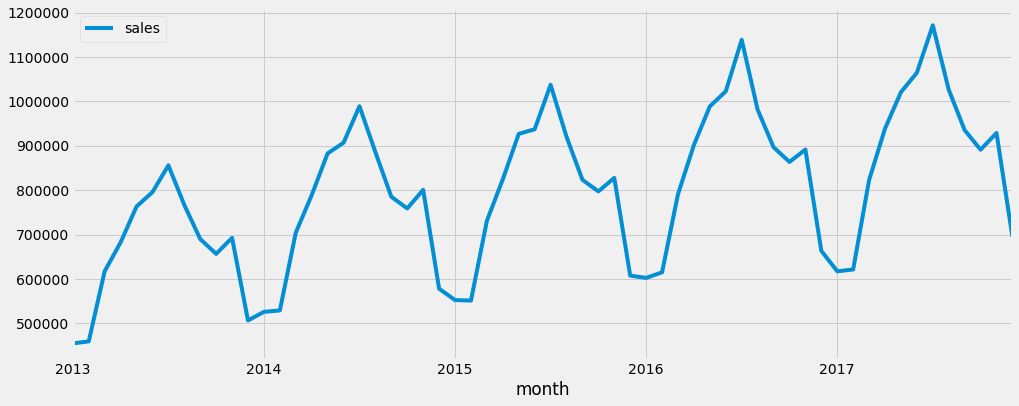

In [13]:
df_month.plot(figsize=(15,6))
plt.show()

#### Reviewing plots of the density of observations can provide further insight into the structure of the data:

- The distribution is not perfectly Gaussian (normal distribution).
- The distribution is left shifted.
- Transformations might be useful prior to modelling.

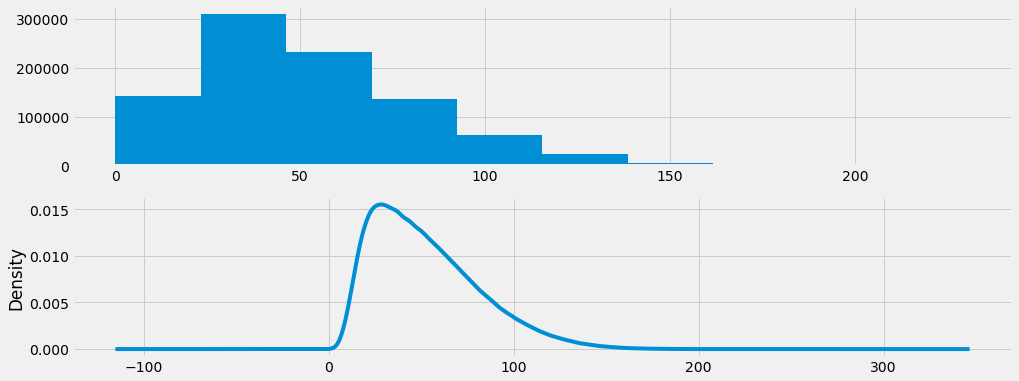

In [14]:
plt.figure(1)
plt.subplot(211)
df.sales.hist()
plt.subplot(212)
df.sales.plot(kind='kde',figsize=(15, 6))
plt.show()

#### Box and Whisker Plots:

- Median values across years confirms an upwards trend
- Slight increase in the spread, or middle 50% of the data (boxes) over time
- A model considering seasonality might work well

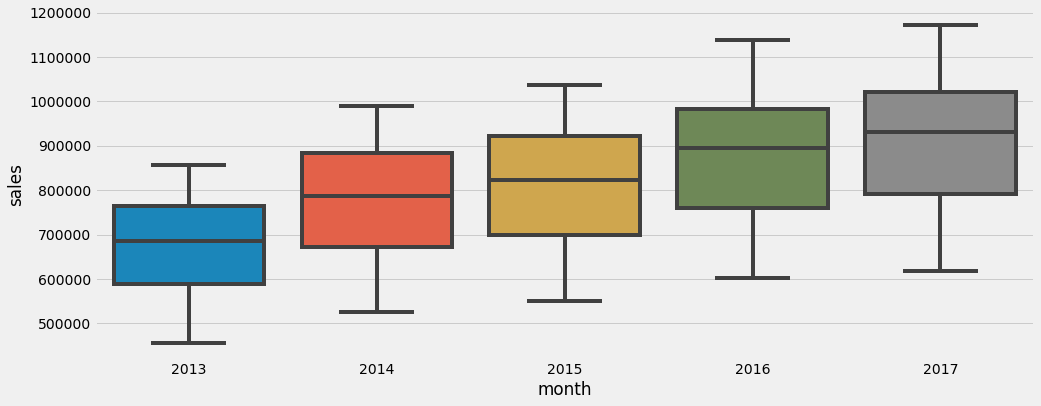

In [15]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(df_month.index.year, df_month.sales, ax=ax);

#### Decomposing using statsmodels:

We can use statsmodels to perform a decomposition of this time series. The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

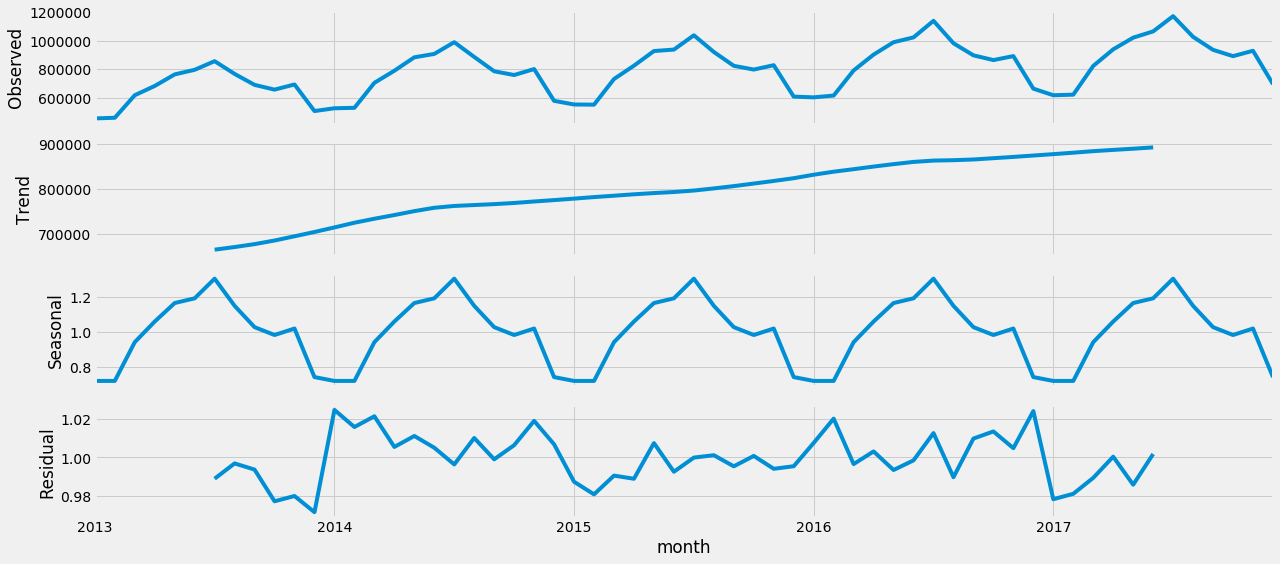

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_month, model='multiplicative', freq=12)
fig = decomposition.plot()
plt.show()

#### Monthly Sales per Item per Store
Exploring the sales of each item per store (item 1 store 1 used below), which is the series that we will ultimately be forecasting, reveals less uniform seasonality from year to year with an overall upwards trend. 

In [17]:
df_item_store = pd.DataFrame({'sales': df[(df['item']==1) & (df['store']==1)].groupby(['month'])['sales'].sum()})

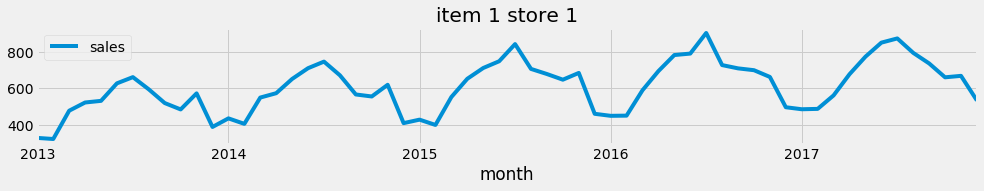

In [18]:
df_item_store.plot(figsize=(15,2),title='item 1 store 1')
plt.show;

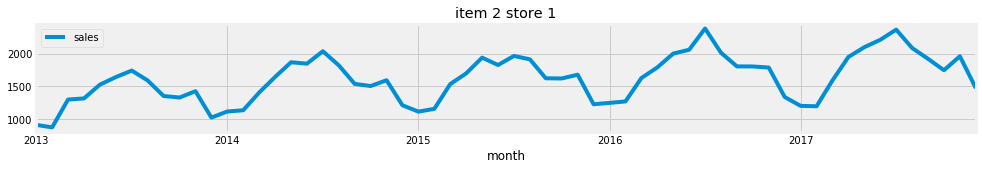

In [13]:
df_item_store2 = pd.DataFrame({'sales': df[(df['item']==2) & (df['store']==1)].groupby(['month'])['sales'].sum()})
df_item_store2.plot(figsize=(15,2),title='item 2 store 1')
plt.show;

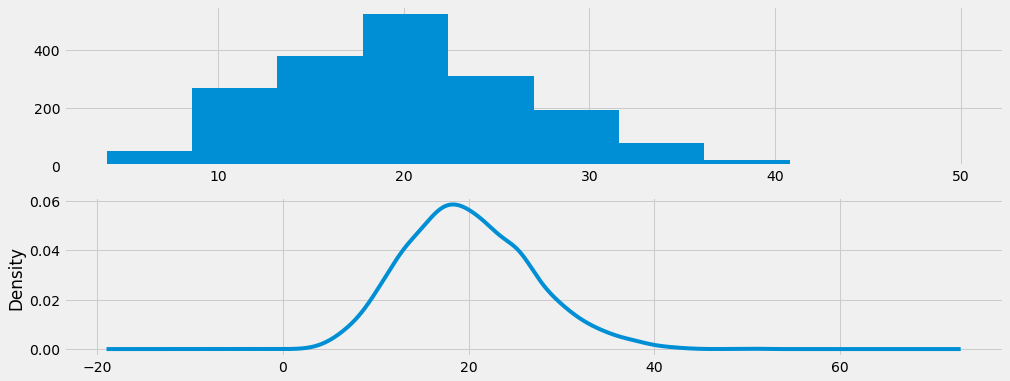

In [19]:
plt.figure(1)
plt.subplot(211)
df[(df['item']==1) & (df['store']==1)].sales.hist()
plt.subplot(212)
df[(df['item']==1) & (df['store']==1)].sales.plot(kind='kde',figsize=(15, 6))
plt.show();

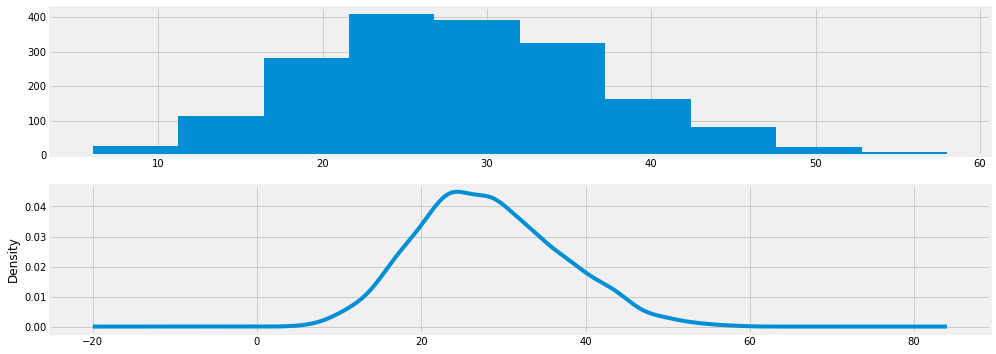

In [16]:
plt.figure(1)
plt.subplot(211)
df[(df['item']==1) & (df['store']==2)].sales.hist()
plt.subplot(212)
df[(df['item']==1) & (df['store']==2)].sales.plot(kind='kde',figsize=(15, 6))
plt.show();

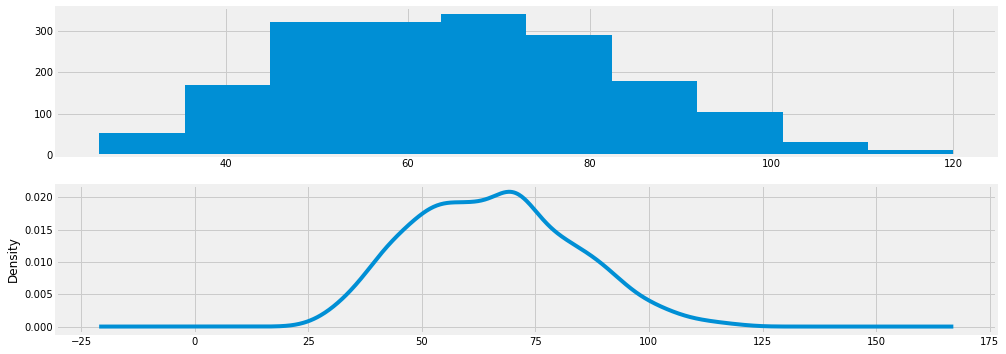

In [17]:
plt.figure(1)
plt.subplot(211)
df[(df['item']==2) & (df['store']==10)].sales.hist()
plt.subplot(212)
df[(df['item']==2) & (df['store']==10)].sales.plot(kind='kde',figsize=(15, 6))
plt.show();

Box and whisker plot shows increase in the spread, or middle 50% of the data (boxes) over time.

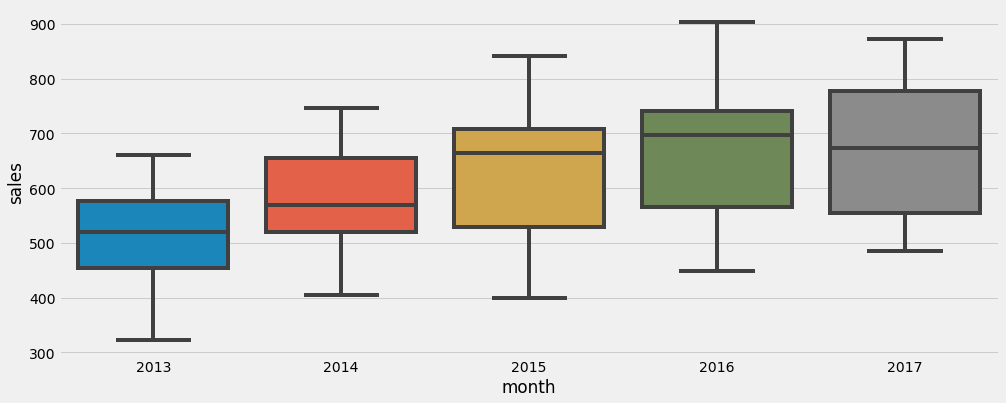

In [20]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(df_item_store.index.year, df_item_store.sales, ax=ax);

Decomposition of the series shows strong upward trend and seasonality. The series will need transformation for stationarity prior to modeling.

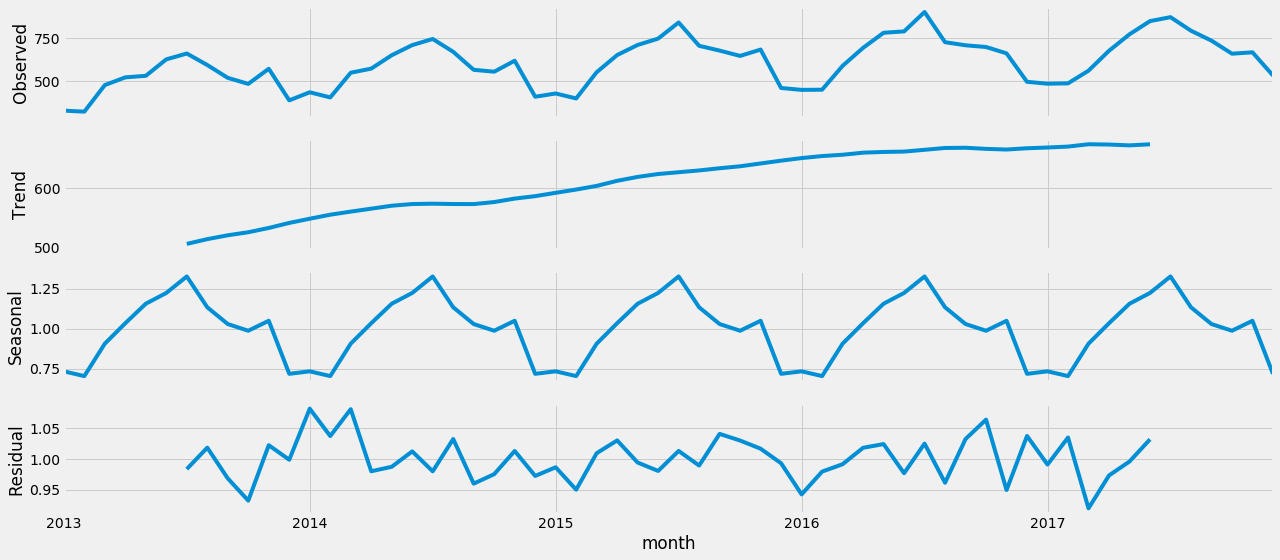

In [21]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_item_store, model='multiplicative', freq=12)
fig = decomposition.plot()
plt.show();

### Extended Date Features

A custom function is written to extend the data with additional features for each date such as its day of week, day of year, section of month and year. These features are used to generate pivot plots of the items sales time series and to perform feature engineering in determining feature importance.

In [14]:
import re
def add_datepart(df, fldname, drop=True):

    """
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','weekofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)

add_datepart(df,'date',False)
df.head()

,date,store,item,sales,month,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2013-01-01,1,1,13,2013-01,2013,1,1,1,1,1,1,False,True,False,True,False,True
1,2013-01-02,1,1,11,2013-01,2013,1,1,2,2,2,1,False,False,False,False,False,False
2,2013-01-03,1,1,14,2013-01,2013,1,1,3,3,3,1,False,False,False,False,False,False
3,2013-01-04,1,1,13,2013-01,2013,1,1,4,4,4,1,False,False,False,False,False,False
4,2013-01-05,1,1,10,2013-01,2013,1,1,5,5,5,1,False,False,False,False,False,False


#### Item Sales by Store
The seasonality of item 1 sales remains consistent across 10 different stores. The differences in sales volumes between stores remain consistent throughout the months. 

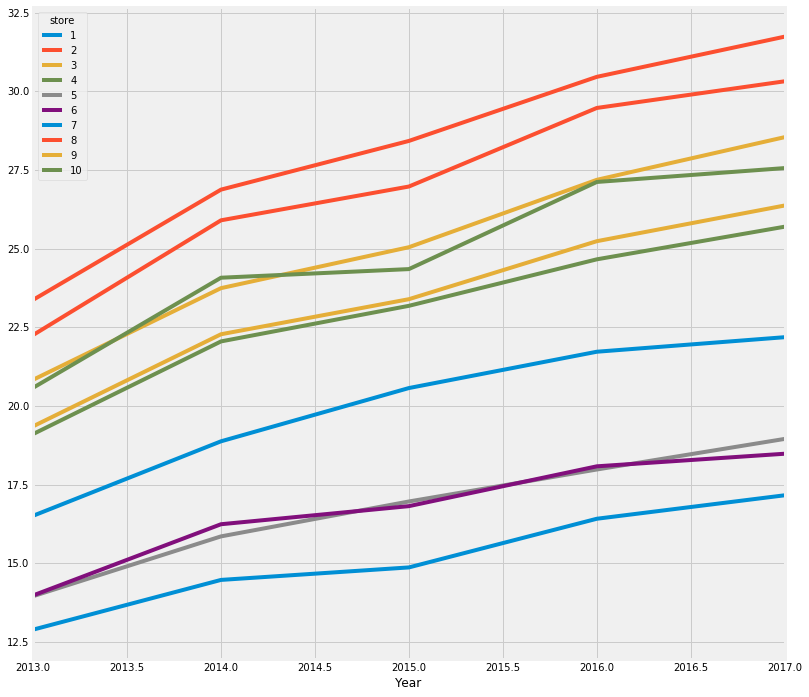

In [15]:
pivoted = pd.pivot_table(df[df['item']==1], values='sales', columns='store', index='Year')
pivoted.plot(figsize=(12,12));

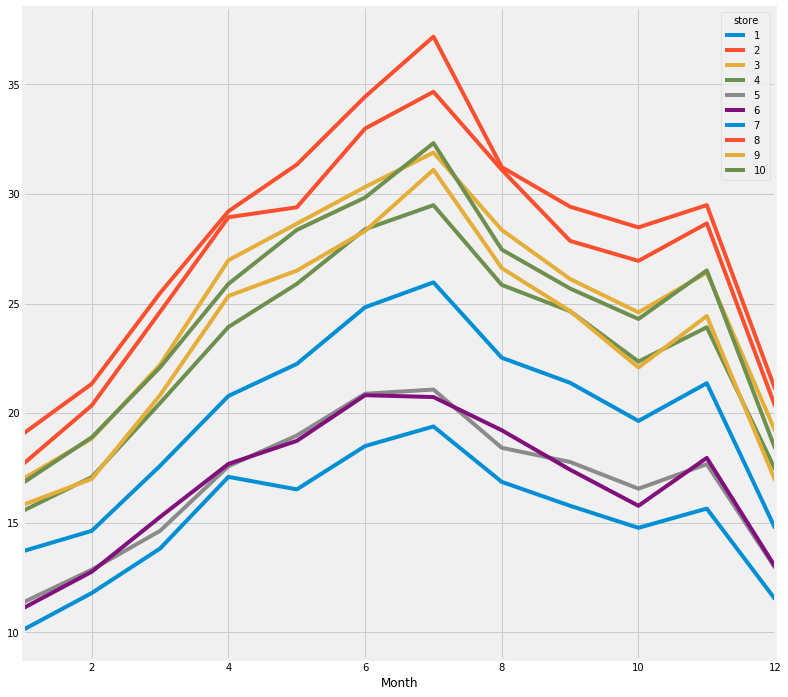

In [9]:
pivoted = pd.pivot_table(df[df['item']==1], values='sales', columns='store', index='Month')
pivoted.plot(figsize=(12,12));

#### Monthly Sales for each Year
Again we see that total sales for all items increased from year to year. With each year maintaing a similar seasonality through the months, climbing to a peak in July and November.

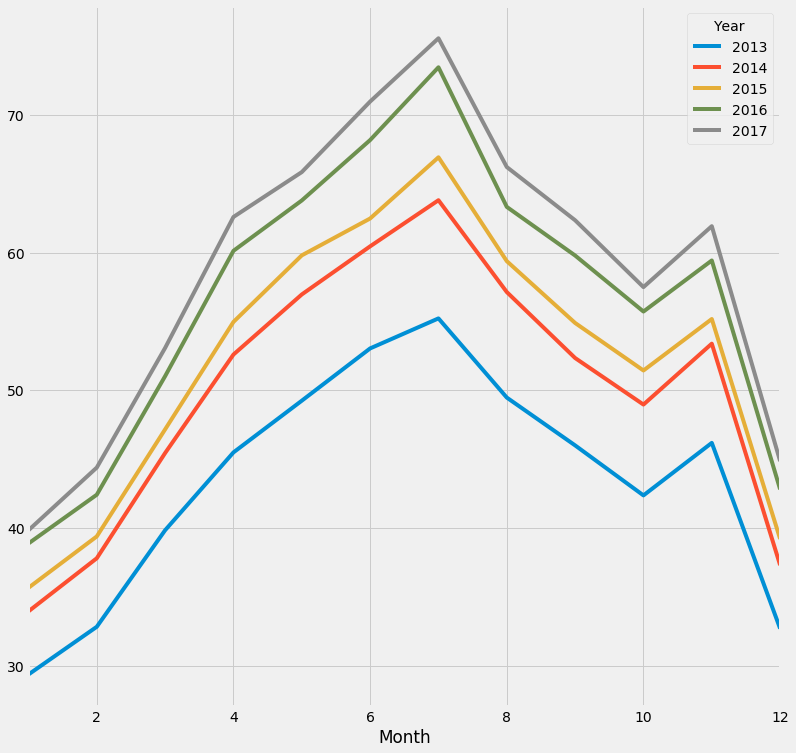

In [31]:
pivoted = pd.pivot_table(df, values='sales', columns='Year', index='Month')
pivoted.plot(figsize=(12,12));

#### Weekly Sales for each Year
All item sales show similar weekly seasonality over the years.

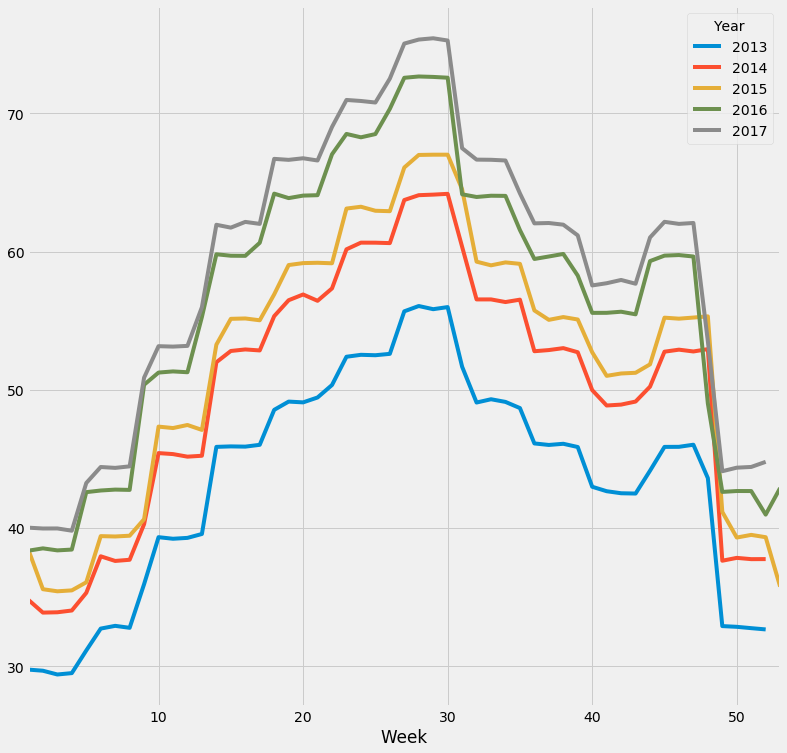

In [32]:
pivoted = pd.pivot_table(df, values='sales' , columns='Year', index='Week')
pivoted.plot(figsize=(12,12));

#### Daily Sales for each Month
Months July and November show more daily sales peaks than the other months.

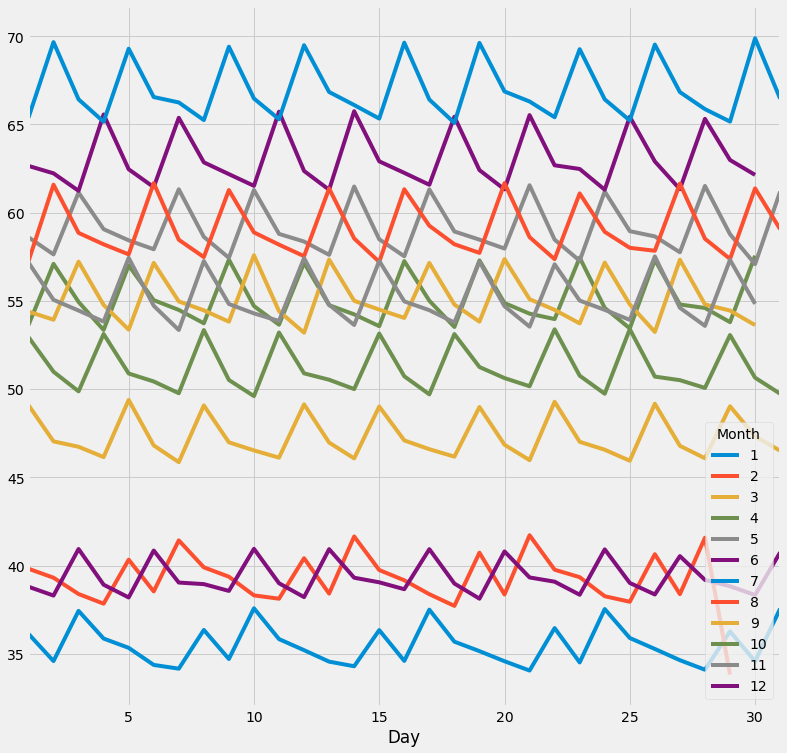

In [33]:
pivoted = pd.pivot_table(df, values='sales' , columns='Month', index='Day')
pivoted.plot(figsize=(12,12));

### Feature Engineering
Combining test and training data, the dataset is extended with date features. Box cox transformation is applied on the sales values to obtain normally distributed data, which is required for training with the LightGBM framework. True and False values in the data are converted to 1 and 0 before training. Tree based learning algorithms from the LightGBM framework are used to determine feature importances.

In [36]:
test_data_path = os.path.join(PROJ_ROOT, "data", "raw", "test.csv")

test_df = pd.read_csv(test_data_path, parse_dates=["date"])
test_df.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [64]:
original_target = df.sales.values
target, lambda_prophet = stats.boxcox(df['sales'] + 1)
len_train=target.shape[0]

In [65]:
merged_df = pd.concat([df, test_df])
merged_df["median-store_item"] = merged_df.groupby(["item", "store"])["sales"].transform("median")
merged_df["mean-store_item"] = merged_df.groupby(["item", "store"])["sales"].transform("mean")
merged_df["mean-Month_item"] = merged_df.groupby(["Month", "item"])["sales"].transform("mean")
merged_df["median-Month_item"] = merged_df.groupby(["Month", "item"])["sales"].transform("median")
merged_df["median-Month_store"] = merged_df.groupby(["Month", "store"])["sales"].transform("median")
merged_df["median-item"] = merged_df.groupby(["item"])["sales"].transform("median")
merged_df["median-store"] = merged_df.groupby(["store"])["sales"].transform("median")
merged_df["mean-item"] = merged_df.groupby(["item"])["sales"].transform("mean")
merged_df["mean-store"] = merged_df.groupby(["store"])["sales"].transform("mean")

merged_df["median-store_item-Month"] = merged_df.groupby(['Month', "item", "store"])["sales"].transform("median")
merged_df["mean-store_item-week"] = merged_df.groupby(["item", "store",'weekofyear'])["sales"].transform("mean")
merged_df["item-Month-mean"] = merged_df.groupby(['Month', "item"])["sales"].transform("mean")# mean sales of that item  for all stores scaled
merged_df["store-Month-mean"] = merged_df.groupby(['Month', "store"])["sales"].transform("mean")# mean sales of that store  for all items scaled


In [66]:
merged_df.drop(['id','date','sales','month'], axis=1, inplace=True)
merged_df.head(1)

,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Month,Week,Year,item,store,weekofyear,median-store_item,mean-store_item,mean-Month_item,median-Month_item,median-Month_store,median-item,median-store,mean-item,mean-store,median-store_item-Month,mean-store_item-week,item-Month-mean,store-Month-mean
0,1.0,1.0,1.0,False,True,False,True,False,True,1.0,1.0,2013.0,1,1,1.0,19.0,19.971522,14.830323,14.0,31.0,21.0,44.0,21.981599,47.268379,13.0,13.970588,14.830323,32.174452


In [67]:
# Convert True and False values to 1 and 0
merged_df = merged_df * 1
params = {
    'nthread': 4,
    'categorical_feature' : [0,1,9,10,12,13,14], # Day, DayOfWeek, Month, Week, Item, Store, WeekOfYear
    'max_depth': 8,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mape', # this is abs(a-e)/max(1,a)
    'num_leaves': 127,
    'learning_rate': 0.25,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 30,
    'lambda_l1': 0.06,
    'lambda_l2': 0.1,
    'verbose': -1
}

A custom function is written to reverse the box cox transformation after the data has been trained and predicted in order to calculate the validation score.

In [61]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

Prior to training and prediction with LightGBM, the data is split into sets for training and validation. Feature importances are obtained after predicting on the test set.

In [68]:
# do the training
num_folds = 3
test_x = merged_df[len_train:].values
all_x = merged_df[:len_train].values
all_y = target # removing what we did earlier

oof_preds = np.zeros([all_y.shape[0]])
sub_preds = np.zeros([test_x.shape[0]])

feature_importance_df = pd.DataFrame()
folds = KFold(n_splits=num_folds, shuffle=True, random_state=345665)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(all_x)):
    
    train_x, train_y = all_x[train_idx], all_y[train_idx]
    valid_x, valid_y = all_x[valid_idx], all_y[valid_idx]
    lgb_train = lgb.Dataset(train_x,train_y)
    lgb_valid = lgb.Dataset(valid_x,valid_y)
        
    # train
    gbm = lgb.train(params, lgb_train, 1000, 
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=100, verbose_eval=100)
    
    oof_preds[valid_idx] = gbm.predict(valid_x, num_iteration=gbm.best_iteration)
    sub_preds[:] += gbm.predict(test_x, num_iteration=gbm.best_iteration) / folds.n_splits
    valid_idx += 1
    importance_df = pd.DataFrame()
    importance_df['feature'] = merged_df.columns
    importance_df['importance'] = gbm.feature_importance()
    importance_df['fold'] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, importance_df], axis=0)
    
e = 2 * abs(all_y - oof_preds) / ( abs(all_y)+abs(oof_preds) )
e = e.mean()
print('Full validation score With Box Cox %.4f' %e)
print('Inverting Box Cox Transformation')
print('Done!!')

sub_preds = inverse_boxcox(sub_preds , lambda_prophet) - 1
oof_preds = inverse_boxcox(oof_preds , lambda_prophet) - 1
e = 2 * abs(all_y - oof_preds) / ( abs(all_y)+abs(oof_preds) )
e = e.mean()
print('Full validation score Re-Box Cox Transformation is %.4f' %e)
#Don't Forget to apply inverse box-cox

Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.050986	valid_1's mape: 0.0540504
Early stopping, best iteration is:
[28]	training's mape: 0.0526041	valid_1's mape: 0.0538132
Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.0511327	valid_1's mape: 0.0538941
Early stopping, best iteration is:
[34]	training's mape: 0.0524707	valid_1's mape: 0.0536535
Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.051089	valid_1's mape: 0.0538863
Early stopping, best iteration is:
[31]	training's mape: 0.0525374	valid_1's mape: 0.0536402
Full validation score With Box Cox 0.0528
Inverting Box Cox Transformation
Done!!
Full validation score Re-Box Cox Transformation is 1.4756


In [69]:
feature_importance_df.head()

,feature,importance,fold
0,Day,506,1
1,Dayofweek,422,1
2,Dayofyear,22,1
3,Is_month_end,1,1
4,Is_month_start,5,1


Plotting the importances in descending order reveals week, item, and day as top features having the biggest impact on sales numbers. In contrast, features store, week of year, and month are of much lesser importance. The results of feature engineering will contribute to more efficient tuning of the seasonal orders in time series models.

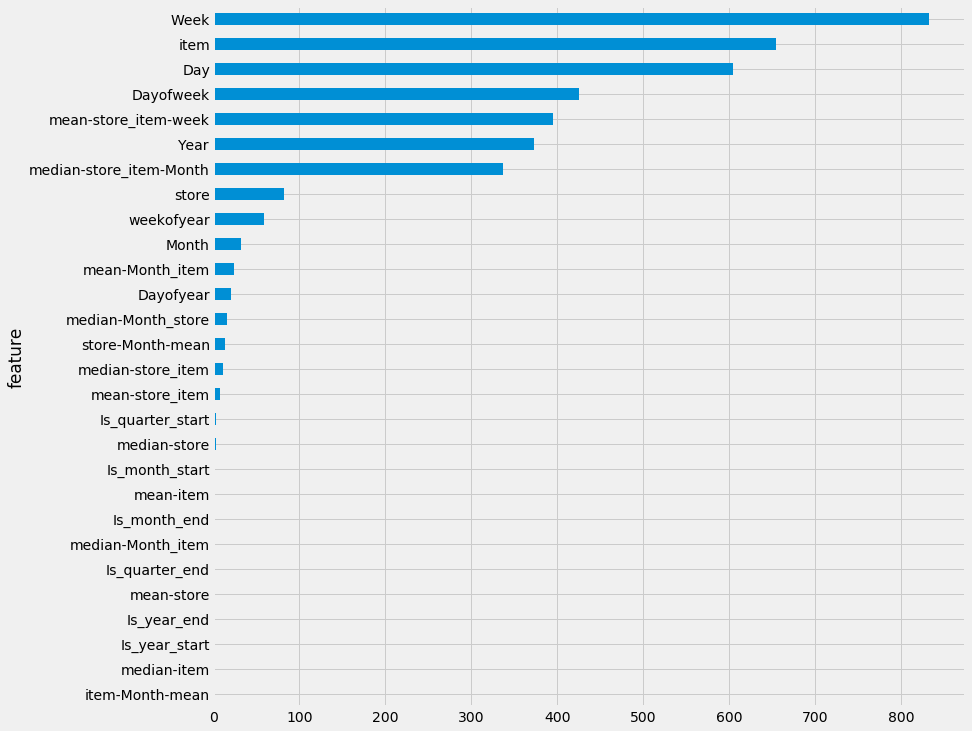

In [73]:
importance_df.sort_values(['importance'], ascending=True, inplace=True);
importance_df[:].plot('feature', 'importance', 'barh', figsize=(12,12), legend=False);

### Stationarity
In order to model a time series, it must be stationary. Most time series models work with stationary time series because non-stationarity increases unpredictability. Newer models like Facebook Prophet provide higher flexibility in dealing with non-stationary time series. Stationary means that the distribution of the data doesn't change with time. For a time series to be stationary, it must fulfill 3 criteria:

- Zero trend: the series does not grow or shrink over time
- Constant variance: average distance of the data points from the zero line does not change
- Constant autocorrelation: how each value in the series is related to its neighbors stays the same

Identifying whether a time series is stationary or non-stationary is very important. If it is stationary, then we can use ARMA models to predict the next values of the time series. If it is non-stationary, then ARMA models cannot be used. However, in most scenarios non-stationary time series can be transformed to stationary ones.

Stationarity can be checked using the augmented Dickey-Fuller Test. Here the null hypothesis is that the time series is non-stationary. The test results comprise of a Test Statistic and some Critical Values at different confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, then the null hypothesis is rejected and the time series is stationary.

#### Augmented Dickey-Fuller Test

The test is performed on item 1 at store 1. Here the test statistic -3.16 is less than the 5% critical value but greater than the 1% critical value, and the p-value 0.02 is greater than 0.05. Since the series has a strong upward trend, we will use the strictest 1% critical value to test the hypothesis. Therefore, we accept the null hypothesis and the time series is non-stationary. Transformations are necessary prior to modeling.

In [22]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df[(df['item']==1) & (df['store']==1)].sales, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -3.157671
p-value                           0.022569
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


## Transformations for Stationarity
Differencing is the technique used below to transform the time series for stationarity. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. First order differencing in Pandas is used.

In [23]:
df_1_1 = df[(df['item']==1) & (df['store']==1)]
diff_1_1 = df_1_1.sales - df_1_1.sales.shift(1)
diff_1_1 = diff_1_1.dropna(inplace = False)

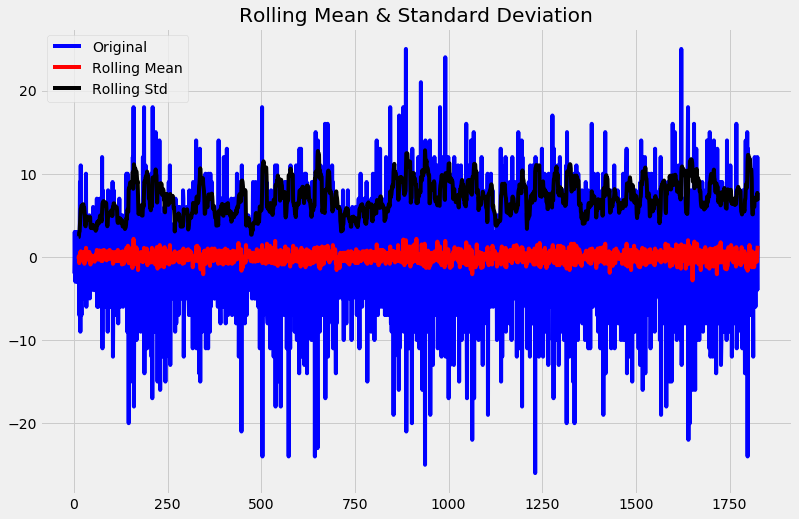

In [24]:
#Get rolling statistics
rolmean = diff_1_1.rolling(12).mean()
rolstd = diff_1_1.rolling(12).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(diff_1_1, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show();

After differencing, the test statistic is less than the 1% critical value and the p-value is much smaller than 0.05. The series also shows constant variance over time upon plotting its rolling statistics. We can now reject the null hypothesis and state that the transformed time series is stationary.

In [25]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(diff_1_1, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.267679e+01
p-value                        1.210928e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.802000e+03
Critical Value (1%)           -3.433984e+00
Critical Value (5%)           -2.863145e+00
Critical Value (10%)          -2.567625e+00
dtype: float64


## Modeling Preparation
Once we know the transformation needed based on the explorations of item 1 at store 1, a custom function is written to prepare the time series of each item per store for modeling. 

In [26]:
# Function that takes a time series dataframe and transforms it with first order differencing, 
# returning the transformed time series as a pandas series
def ts_diff(ts):
    diff = ts.sales - ts.sales.shift(1)
    return diff.dropna()

In [27]:
# Create arrays of item numbers and store numbers for iterating through
items = np.arange(1,51)
stores = np.arange(1,11)

# Call transformation function for the time series of each item in each store and append the result to an array
ts = [ts_diff(df[(df['item']==i) & (df['store']==s)]) for i in items for s in stores]

## Summary

The item sales dataset includes the sales data for 50 items across 10 stores over 5 years in time. Exploratory data analysis by plotting the time series of total sales, as well as the sales of each item per store reveals strong upwards trend and seasonality. The augmented Dickey-Fuller test for stationarity in trend provides a test statistic that is greater than the 1% critical value and a p-value greater than 0.05, which accepts the null hypothesis of the time series having a trend that is non-stationary.

Using first order differencing, the time series is transformed for trend stationarity. However, there is still seasonality to consider when modeling the time series. SARIMA model can be used for the time series when dealing with seasonality.

In [28]:
%store ts

Stored 'ts' (list)


In [29]:
%store df

Stored 'df' (DataFrame)
